In [238]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

In [239]:
with open(r'data\answer\answer_data_annotations.json', 'r') as f:
    answer_annotations = json.load(f)

with open(r'data\wrong\wrong_data_annotations.json', 'r') as f:
    wrong_annotations = json.load(f)

In [240]:
answer_data = 'answer_annotated_data.csv'
wrong_data = 'wrong_annotated_data.csv'

In [241]:
answer_data = pd.read_csv(answer_data)
wrong_data = pd.read_csv(wrong_data)

In [242]:
answer_data['Label'] = 1  # 정답 데이터 ==> label 1
wrong_data['Label'] = 0  # 오답 데이터 ==> label 0

In [243]:
def get_video_data(data, annotations):
    video_data = []
    for video in annotations['videos']:
        frames = [int(frame['frame'].split('_')[-1].split('.')[0]) for frame in video['annotations']]
        video_data.append(data.loc[frames].reset_index(drop=True))  # 인덱스 리셋
    return video_data

In [244]:
answer_videos = get_video_data(answer_data, answer_annotations)
wrong_videos = get_video_data(wrong_data, wrong_annotations)

In [245]:
all_videos = answer_videos + wrong_videos

In [246]:
scaler = MinMaxScaler()
scaler.fit(pd.concat(all_videos).select_dtypes(include = [np.number]))

MinMaxScaler()

In [247]:
def scale_videos(videos, scaler):
    scaled_videos = []
    for video in videos:
        features = video.select_dtypes(include=[np.number]).columns.difference(['Label'])  # 숫자형 데이터만 select
        scaled_data = scaler.fit_transform(video[features])
        scaled_video = pd.DataFrame(scaled_data, columns=features)
        scaled_video['Label'] = video['Label'].values
        scaled_videos.append(scaled_video)
    return scaled_videos

In [248]:
scaled_videos = scale_videos(all_videos, scaler)

In [249]:
def create_dataset_rf(videos, time_step=10):
    dataX, dataY = [], [] # dataX가 flatten된 시계열 데이터, dataY가 레이블
    for video in videos:
        dataset = video.drop(columns=['Label']).values
        labels = video['Label'].values
        for i in range(len(dataset) - time_step):
            a = dataset[i:(i + time_step)].flatten() ## i에서 time_step 까지의 데이터 가져오고 flatten
            dataX.append(a)
            dataY.append(labels[i + time_step]) # 레이블은 바로 다음 레이블 입력. 시계열 데이터 특성 반영
    return np.array(dataX), np.array(dataY)

In [250]:
time_step = 3 # 10개 연속된 데이터 설정.
X_rf, y_rf = create_dataset_rf(scaled_videos, time_step)

In [251]:
## 기존 trian, test, vali 셋 구분지어 놓은 것, train, vali 셋으로만 분리 수정

# X_train_rf, X_temp_rf, y_train_rf, y_temp_rf = train_test_split(X_rf, y_rf, test_size=0.4, random_state=42, stratify=y_rf) # stratify로 각 클래스 비율 유지.
# X_val_rf, X_test_rf, y_val_rf, y_test_rf = train_test_split(X_temp_rf, y_temp_rf, test_size=0.5, random_state=42, stratify=y_temp_rf)

X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_rf, y_rf, test_size=0.4, random_state=42, stratify=y_rf)

oversample = RandomOverSampler(sampling_strategy='minority') # 적은 클래스(Label => 0), 많은 클래스(Label => 1) 동일 수 맞추기

X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train_rf, y_train_rf)

In [252]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 10, min_samples_split = 5, class_weight = 'balanced')
model_rf.fit(X_train_oversampled, y_train_oversampled)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, random_state=42)

In [253]:
# 훈련셋 성능

y_train_pred_rf = model_rf.predict(X_train_oversampled)

print(f'training set accuracy: {accuracy_score(y_train_oversampled, y_train_pred_rf)}')
print(f'trainint set report: \n {classification_report(y_train_oversampled, y_train_pred_rf)}')

training set accuracy: 1.0
trainint set report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



trainint_set C_M_: 
[[138   0]
 [  0 138]]


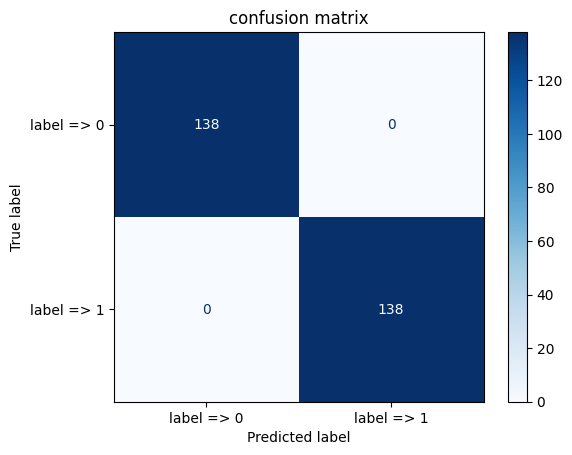

In [254]:
# confusion maxtrix

cm_train = confusion_matrix(y_train_oversampled, y_train_pred_rf)

print(f'trainint_set C_M_: \n{cm_train}')

ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['label => 0', 'label => 1']).plot(cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

In [255]:
# vali set
y_val_pred_rf = model_rf.predict(X_val_rf)
accuracy_val_rf = accuracy_score(y_val_rf, y_val_pred_rf)
report_val_rf = classification_report(y_val_rf, y_val_pred_rf)

In [256]:
print(f'Vali set Accuracy: {accuracy_val_rf}')
print(f'Vali set Report:\n{report_val_rf}')

Vali set Accuracy: 1.0
Vali set Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        93

    accuracy                           1.00       152
   macro avg       1.00      1.00      1.00       152
weighted avg       1.00      1.00      1.00       152



vali set C_M_: 
[[59  0]
 [ 0 93]]


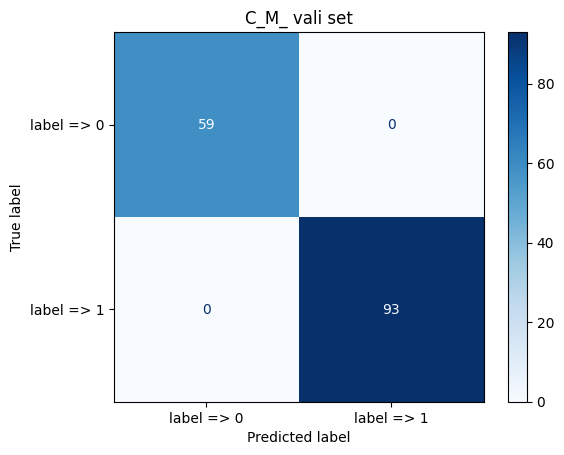

In [257]:
cm_val = confusion_matrix(y_val_rf, y_val_pred_rf)
print(f'vali set C_M_: \n{cm_val}')
ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['label => 0', 'label => 1']).plot(cmap=plt.cm.Blues)
plt.title('C_M_ vali set')
plt.show()

In [258]:
test_answer_annotations = json.load(open(r'data\test\answer\test_answer_data_annotations.json', 'r'))
test_wrong_annotations = json.load(open(r'data\test\wrong\test_wrong_data_annotations.json', 'r'))

In [259]:
test_answer_data = pd.read_csv('test_answer_annotated_data.csv')
test_wrong_data = pd.read_csv('test_wrong_annotated_data.csv')

In [260]:
test_answer_data['Label'] = 1  # 정답 데이터 ==> label 1
test_wrong_data['Label'] = 0  # 오답 데이터 ==> label 0


In [261]:
test_answer_videos = get_video_data(test_answer_data, test_answer_annotations)
test_wrong_videos = get_video_data(test_wrong_data, test_wrong_annotations)

In [262]:
test_all_videos = test_answer_videos + test_wrong_videos

In [263]:
scaled_test_videos = scale_videos(test_all_videos, scaler)

In [264]:
X_test_rf, y_test_rf = create_dataset_rf(scaled_test_videos, time_step)

In [265]:
y_test_pred_rf = model_rf.predict(X_test_rf)
accuracy_test_rf = accuracy_score(y_test_rf, y_test_pred_rf)
report_test_rf = classification_report(y_test_rf, y_test_pred_rf)
print(f'Test Accuracy: {accuracy_test_rf}')
print(f'Test Report:\n{report_test_rf}')

Test Accuracy: 0.5
Test Report:
              precision    recall  f1-score   support

           0       0.52      0.36      0.43        88
           1       0.49      0.64      0.56        84

    accuracy                           0.50       172
   macro avg       0.50      0.50      0.49       172
weighted avg       0.50      0.50      0.49       172



In [266]:
#with open('running_posture_model_edit_frame.pkl', 'wb') as model_file:
#    pickle.dump(model_rf, model_file)

In [267]:
#with open('data_scaler_edit_frame.pkl', 'wb') as scaler_file:
#    pickle.dump(scaler, scaler_file)